In [1]:
import uproot, pylhe, glob, os
import numpy as np
import numba,vector
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd 
import seaborn as sns

In [2]:
lhe_signal=glob.glob("/localscratch/Samples/Signal/SM/WWW01j_000[0-4].lhe.gz")
root_signal=glob.glob("/localscratch/Samples/Signal/SM/WWW01j_000[0-4].root")

lhe_bkg=glob.glob("/localscratch/Samples/3l01j/3l01j_00[0-1]?.lhe.gz")
root_bkg=glob.glob("/localscratch/Samples/3l01j/3l01j_00[0-1]?.root")

print(root_bkg)

['/localscratch/Samples/3l01j/3l01j_0018.root', '/localscratch/Samples/3l01j/3l01j_0013.root', '/localscratch/Samples/3l01j/3l01j_0007.root', '/localscratch/Samples/3l01j/3l01j_0001.root', '/localscratch/Samples/3l01j/3l01j_0012.root', '/localscratch/Samples/3l01j/3l01j_0015.root', '/localscratch/Samples/3l01j/3l01j_0006.root', '/localscratch/Samples/3l01j/3l01j_0002.root', '/localscratch/Samples/3l01j/3l01j_0010.root', '/localscratch/Samples/3l01j/3l01j_0016.root', '/localscratch/Samples/3l01j/3l01j_0008.root', '/localscratch/Samples/3l01j/3l01j_0009.root', '/localscratch/Samples/3l01j/3l01j_0014.root', '/localscratch/Samples/3l01j/3l01j_0005.root', '/localscratch/Samples/3l01j/3l01j_0019.root', '/localscratch/Samples/3l01j/3l01j_0000.root', '/localscratch/Samples/3l01j/3l01j_0004.root', '/localscratch/Samples/3l01j/3l01j_0003.root', '/localscratch/Samples/3l01j/3l01j_0017.root', '/localscratch/Samples/3l01j/3l01j_0011.root']


In [3]:
def get_xSection(lhefiles):
    init=pylhe.read_lhe_init(lhefiles[0])

    xSection=0.
    for process in init['procInfo']:
        xSection+=process['xSection']
    return xSection # in pb

In [4]:
def getNeventsLHE(lhefiles):
    N=0
    for f in lhefiles:
        lines=os.popen('zgrep "</event>" '+f+"|wc -l").readlines()
        N+=int(lines[0])
    return N

In [5]:
xSection_sig=get_xSection(lhe_signal)
xSection_bkg=get_xSection(lhe_bkg)
print(xSection_sig,xSection_bkg)

0.017245120000000003 0.8901096


In [6]:
N_lhe_sig=1000000 #getNeventsLHE(lhe_signal)
N_lhe_bkg=4000000 #getNeventsLHE(lhe_bkg)
print(N_lhe_sig,N_lhe_bkg)

1000000 4000000


In [7]:
def getNeventsRoot(rootfiles):
    N=0
    for f in rootfiles:
        with uproot.open(f+':Delphes') as tree:
            N+=tree.num_entries
    return N

In [8]:
N_root_sig=511723 #getNeventsRoot(root_signal)
N_root_bgk=2964674 #getNeventsRoot(root_bkg)
print(N_root_sig,N_root_bgk)

511723 2964674


In [9]:
#calculate resulting xSection*efficiency
xSection_sig*=N_root_sig/N_lhe_sig
xSection_bkg*=N_root_bgk/N_lhe_bkg
print(xSection_sig,xSection_bkg)

0.008824724541760002 0.6597211970676


In [10]:
#show available branches
tree=uproot.open(root_signal[0]+':Delphes')
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
Event                | int32_t                  | AsDtype('>i4')
Event/Event.fUniq... | uint32_t[]               | AsJagged(AsDtype('>u4'))
Event/Event.fBits    | uint32_t[]               | AsJagged(AsDtype('>u4'))
Event/Event.Number   | int64_t[]                | AsJagged(AsDtype('>i8'))
Event/Event.ReadTime | float[]                  | AsJagged(AsDtype('>f4'))
Event/Event.ProcTime | float[]                  | AsJagged(AsDtype('>f4'))
Event/Event.Proce... | int32_t[]                | AsJagged(AsDtype('>i4'))
Event/Event.MPI      | int32_t[]                | AsJagged(AsDtype('>i4'))
Event/Event.Weight   | float[]                  | AsJagged(AsDtype('>f4'))
Event/Event.Cross... | float[]                  | AsJagged(AsDtype('>f4'))
Event/Event.Cross... | float[]                  | AsJagged(AsDtype('>f4'))
Event/Event.Scale    | 

In [11]:
#show only specifc elements
tree['MissingET'].show(filter_name="MissingET.*")

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
MissingET            | int32_t                  | AsDtype('>i4')                
MissingET.fUniqueID  | uint32_t[]               | AsJagged(AsDtype('>u4'))
MissingET.fBits      | uint32_t[]               | AsJagged(AsDtype('>u4'))
MissingET.MET        | float[]                  | AsJagged(AsDtype('>f4'))
MissingET.Eta        | float[]                  | AsJagged(AsDtype('>f4'))
MissingET.Phi        | float[]                  | AsJagged(AsDtype('>f4'))


In [12]:

tree['Electron'].show(filter_name="Electron.*", name_width=40)

name                                     | typename                 | interpretation                
-----------------------------------------+--------------------------+-------------------------------
Electron                                 | int32_t                  | AsDtype('>i4')                
Electron.fUniqueID                       | uint32_t[]               | AsJagged(AsDtype('>u4'))
Electron.fBits                           | uint32_t[]               | AsJagged(AsDtype('>u4'))
Electron.PT                              | float[]                  | AsJagged(AsDtype('>f4'))
Electron.Eta                             | float[]                  | AsJagged(AsDtype('>f4'))
Electron.Phi                             | float[]                  | AsJagged(AsDtype('>f4'))
Electron.T                               | float[]                  | AsJagged(AsDtype('>f4'))
Electron.Charge                          | int32_t[]                | AsJagged(AsDtype('>i4'))
Electron.EhadOverEem            

In [13]:
#specify the variables we are interested in
tree.keys(filter_name="/(MissingET.(MET|Phi)|Particle.(PID|Status)|Electron.(PT|Eta|Phi|Charge)|"
          "Muon.(PT|Eta|Phi|Charge)|Jet.(PT|Eta|Phi))/")

['Particle/Particle.PID',
 'Particle/Particle.Status',
 'Jet/Jet.PT',
 'Jet/Jet.Eta',
 'Jet/Jet.Phi',
 'Jet/Jet.PTD',
 'Electron/Electron.PT',
 'Electron/Electron.Eta',
 'Electron/Electron.Phi',
 'Electron/Electron.Charge',
 'Muon/Muon.PT',
 'Muon/Muon.Eta',
 'Muon/Muon.Phi',
 'Muon/Muon.Charge',
 'MissingET/MissingET.MET',
 'MissingET/MissingET.Phi']

In [14]:
@numba.jit(nopython=True)
def checkHiggs(batch):
    higgs=np.full((len(batch),),False)
    for i in range(len(batch)):
        for p in range(len(batch[i]['Particle.PID'])):
            if abs(batch[i]['Particle.PID'][p])==25:
                higgs[i]=True
                break
    return higgs

In [15]:
@numba.jit(nopython=True)
def preselection(batch):
    pass_selection=np.full((len(batch),),False)
    for i in range(len(batch)):
        nElectrons=0
        nMuons=0
        nJets=0

        for e in range(len(batch[i]['Electron.PT'])):
            if batch[i]['Electron.PT'][e]>=10.0 and abs(batch[i]['Electron.Eta'][e])<2.5:
                nElectrons+=1


        for m in range(len(batch[i]['Muon.PT'])):
            if batch[i]['Muon.PT'][m]>=10.0 and abs(batch[i]['Muon.Eta'][m])<2.5:
                nMuons+=1

        for j in range(len(batch[i]['Jet.PT'])):
            if batch[i]['Jet.PT'][j]>=25.0 and abs(batch[i]['Jet.Eta'][j])<2.5:
                nJets+=1

        if nElectrons+nMuons==3 and nJets<5:
            pass_selection[i]=True

    return pass_selection
    

In [16]:
@numba.jit(nopython=True)
def get_MET(batch):
    met=np.zeros((len(batch),))
    metPhi=np.zeros((len(batch),))
    for i in range(len(batch)):
        met[i]=float(batch[i]['MissingET.MET'][0])
        metPhi[i]=float(batch[i]['MissingET.Phi'][0])
    return met, metPhi

In [23]:
#selects which data type we are putting through the processing
def batch_selector(batch, decay):
    higgs = checkHiggs(batch)
    presel = preselection(batch)
    if decay == 0:#VH
        batch = batch[np.logical_and(higgs,presel)]
    elif decay == 1:#WWW
        batch = batch[np.logical_and(~higgs,presel)]
    else: #other ie bkg
        batch = batch[presel]
    
    return batch


In [64]:
#get l0, l1, l2 where l0 has unique charge, l1 is closest to it and l2 is the other
@numba.jit(nopython=True)
def get_leptons(batch):
    PT_l0=np.full((len(batch),),1000.)
    PT_l1=np.full((len(batch),),1000.)
    PT_l2=np.full((len(batch),),1000.)
    invarM=np.full((len(batch),),1000.)
    invarM_l0l2=np.full((len(batch),),1000.)
    invarM_l1l2=np.full((len(batch),),1000.)
    invarM_l0l1=np.full((len(batch),),1000.)
    E_l1l2=np.full((len(batch),),1000.)
    E_l0l2=np.full((len(batch),),1000.)
    E_l0l1=np.full((len(batch),),1000.)
    transM_l1l2=np.full((len(batch),),1000.)
    transM_l0l2=np.full((len(batch),),1000.)    
    transM_l0l1=np.full((len(batch),),1000.)
    deltaeta_l1l2=np.full((len(batch),),1000.)
    deltaeta_l0l2=np.full((len(batch),),1000.)
    deltaeta_l0l1=np.full((len(batch),),1000.)
    deltaangle_l1l2=np.full((len(batch),),1000.)
    deltaangle_l0l2=np.full((len(batch),),1000.)
    deltaangle_l0l1=np.full((len(batch),),1000.)
    dR_l1l2 = np.full((len(batch),),1000.)
    dR_l0l1 = np.full((len(batch),),1000.)
    dR_l0l2 = np.full((len(batch),),1000.)
    totalP = np.full((len(batch),),1000.)
    DRll=np.full((len(batch),),1000.)
    invarM=np.full((len(batch),),1000.)

    met, metPhi = get_MET(batch)
    lepton0s = []
    leptons=[]
    for i in range(len(batch)):
        charges = []
        #loop over electrons
        for e in range(len(batch[i]['Electron.PT'])):
            l = vector.obj(pt=batch[i]['Electron.PT'][e], 
                                      phi=batch[i]['Electron.Phi'][e], 
                                      eta=batch[i]['Electron.Eta'][e], 
                                      mass=511./1e6)

            charges.append(batch[i]['Electron.Charge'][e])
            leptons.append(l)
            
        #loop over muons
        for m in range(len(batch[i]['Muon.PT'])):
            l = vector.obj(pt=batch[i]['Muon.PT'][m], 
                                      phi=batch[i]['Muon.Phi'][m], 
                                      eta=batch[i]['Muon.Eta'][m], 
                                      mass=105.66/1e3)

            charges.append(batch[i]['Muon.Charge'][m])
            leptons.append(l)

        if charges[0] == charges[1]:
            lepton0s.append(leptons[2])
        elif charges[0] == charges[2]:
            lepton0s.append(leptons[1])
        else:
            lepton0s.append(leptons[0])  


        l0 = lepton0s[0]
        mindr=DRll[i]
        for l in leptons:
            if l==l0:
                continue
            if l.deltaR(l0)<mindr:
                mindr=l.deltaR(l0)
                l1 = l
        for l in leptons:
            if l == l0:
                continue 
            elif l== l1:
                continue
            else:
                l2 = l 
        DRll[i] = mindr

        PT_l0[i] = l0.p
        PT_l1[i] = l1.p
        PT_l2[i] = l2.p
        
        invarM[i] = (l0 + l1 + l2).M
        
        invarM_l0l2[i]=(l0+l2).M
        invarM_l1l2[i]=(l1+l2).M
        invarM_l0l1[i]=(l0+l1).M
        
        E_l1l2[i]=np.sqrt((l1+l2).p2 + invarM_l1l2[i])
        E_l0l2[i]=np.sqrt((l0+l2).p2 + invarM_l0l2[i])
        E_l0l1[i]=np.sqrt((l0+l1).p2 + invarM_l0l1[i])
        
        transM_l1l2[i]=np.sqrt(np.abs(((E_l1l2[i]+met[i])**2 - np.abs(l1.p * l2.p + met[i])**2)))
        transM_l0l2[i]=np.sqrt(np.abs(((E_l0l2[i]+met[i])**2 - np.abs(l0.p * l2.p + met[i])**2)))
        transM_l0l1[i]=np.sqrt(np.abs(((E_l0l1[i]+met[i])**2 - np.abs(l0.p * l1.p + met[i])**2)))

        deltaeta_l1l2[i]=l1.deltaeta(l2)
        deltaeta_l0l2[i]=l0.deltaeta(l2)
        deltaeta_l0l1[i]=l0.deltaeta(l1)

        deltaangle_l1l2[i]=l1.deltaangle(l2)
        deltaangle_l0l2[i]=l0.deltaangle(l2)
        deltaangle_l0l1[i]=l0.deltaangle(l1)

        dR_l1l2[i] = l1.deltaR(l2)
        dR_l0l1[i] = l0.deltaR(l1)
        dR_l0l2[i] = l0.deltaR(l2)

        totalP[i] = l0.p + l1.p + l2.p 

        
    return PT_l0, PT_l1, PT_l2, met, metPhi, invarM_l0l1, invarM_l0l2, invarM_l1l2, invarM, \
                transM_l0l1, transM_l0l2, transM_l1l2, \
                deltaeta_l0l1, deltaeta_l0l2, deltaeta_l1l2, \
                deltaangle_l0l1, deltaangle_l0l2, deltaangle_l1l2, \
                dR_l0l1, dR_l0l2, dR_l1l2, totalP, DRll
                

In [65]:
ntotal_VH=0
nselected_VH=0
df_VH = None

myfilter="/(MissingET.(MET|Phi)|Particle.(PID|Status)|Electron.(PT|Eta|Phi|Charge)|Muon.(PT|Eta|Phi|Charge)|Jet.(PT|Eta|Phi))/"
batch_size=5000
iterator = uproot.iterate([f+":Delphes" for f in root_signal],step_size=batch_size, filter_name=myfilter)

for batch in tqdm(iterator, total=N_root_sig//batch_size):
    higgs = checkHiggs(batch)
    presel = preselection(batch)
    ntotal_VH+=higgs.sum()
    nselected_VH+=np.logical_and(higgs,presel).sum()
    
    batch = batch_selector(batch, 0) #VH data
    
    PT_l0, PT_l1, PT_l2, met, metPhi, invarM_l0l1, invarM_l0l2, invarM_l1l2, invarM, \
            transM_l0l1, transM_l0l2, transM_l1l2, \
            deltaeta_l0l1, deltaeta_l0l2, deltaeta_l1l2, \
            deltaangle_l0l1, deltaangle_l0l2, deltaangle_l1l2, \
            dR_l0l1, dR_l0l2, dR_l1l2, totalP, dRmin = get_leptons(batch)
    
    dataset = {'PT_l0': PT_l0, 'PT_l1': PT_l1, 'PT_l2': PT_l2, 'met': met, 'metPhi': metPhi,
       'm_l0l1': invarM_l0l1, 'm_l0l2': invarM_l0l2, 'm_l1l2': invarM_l1l2, 'm_lll': invarM,
       'mT_l0l1': transM_l0l1, 'mT_l0l2': transM_l0l2, 'mT_l1l2': transM_l1l2, 
       'delEta_l0l1': deltaeta_l0l1, 'delEta_l0l2': deltaeta_l0l2, 'delEta_l1l2': deltaeta_l1l2,
      'delPhi_l0l1': deltaangle_l0l1, 'delPhi_l0l2': deltaangle_l0l2, 'delPhi_l1l2': deltaangle_l1l2,
      'delR_l0l1': dR_l0l1, 'delR_l0l2': dR_l0l2, 'delR_l1l2': dR_l1l2, 
        'sumPT': totalP, 'dRmin': dRmin} #make into dict
    
    
    if df_VH is not None:
            newdata_VH = pd.DataFrame(dataset)
            df_VH = pd.concat([df_VH, newdata_VH], axis = 0, ignore_index=True)
            
    else:
        df_VH = pd.DataFrame(dataset)

    
                  
print("Preselection efficiency for VH events: %2.2f %%"%(100.*nselected_VH/ntotal_VH))
df_VH.insert(loc=0, column='Type', value=0)

105it [00:06, 17.41it/s]                                                        

Preselection efficiency for VH events: 41.70 %


In [66]:
ntotal_WWW=0
nselected_WWW=0
df_WWW = None

myfilter="/(MissingET.(MET|Phi)|Particle.(PID|Status)|Electron.(PT|Eta|Phi|Charge)|Muon.(PT|Eta|Phi|Charge)|Jet.(PT|Eta|Phi))/"
batch_size=5000
iterator = uproot.iterate([f+":Delphes" for f in root_signal],step_size=batch_size, filter_name=myfilter)

for batch in tqdm(iterator, total=N_root_sig//batch_size):
    higgs = checkHiggs(batch)
    presel = preselection(batch)
    ntotal_WWW+=higgs.sum()
    nselected_WWW+=np.logical_and(higgs,presel).sum()
    
    batch = batch_selector(batch, 1) #WWW data
    
    PT_l0, PT_l1, PT_l2, met, metPhi, invarM_l0l1, invarM_l0l2, invarM_l1l2, invarM, \
            transM_l0l1, transM_l0l2, transM_l1l2, \
            deltaeta_l0l1, deltaeta_l0l2, deltaeta_l1l2, \
            deltaangle_l0l1, deltaangle_l0l2, deltaangle_l1l2, \
            dR_l0l1, dR_l0l2, dR_l1l2, totalP, dRmin = get_leptons(batch)
    
    dataset = {'PT_l0': PT_l0, 'PT_l1': PT_l1, 'PT_l2': PT_l2, 'met': met, 'metPhi': metPhi,
       'm_l0l1': invarM_l0l1, 'm_l0l2': invarM_l0l2, 'm_l1l2': invarM_l1l2, 'm_lll': invarM,
       'mT_l0l1': transM_l0l1, 'mT_l0l2': transM_l0l2, 'mT_l1l2': transM_l1l2, 
       'delEta_l0l1': deltaeta_l0l1, 'delEta_l0l2': deltaeta_l0l2, 'delEta_l1l2': deltaeta_l1l2,
      'delPhi_l0l1': deltaangle_l0l1, 'delPhi_l0l2': deltaangle_l0l2, 'delPhi_l1l2': deltaangle_l1l2,
      'delR_l0l1': dR_l0l1, 'delR_l0l2': dR_l0l2, 'delR_l1l2': dR_l1l2, 
        'sumPT': totalP, 'dRmin': dRmin} #make into dict
    
    
    if df_WWW is not None:
            newdata_WWW = pd.DataFrame(dataset)
            df_WWW = pd.concat([df_WWW, newdata_WWW], axis = 0, ignore_index=True)
            
    else:
        df_WWW = pd.DataFrame(dataset)
print("Preselection efficiency for WWW events: %2.2f %%"%(100.*nselected_WWW/ntotal_WWW))

df_WWW.insert(loc=0, column='Type', value=1)

105it [00:05, 19.13it/s]                                                        

Preselection efficiency for WWW events: 41.70 %


In [67]:
df_WWW.head()

,Type,PT_l0,PT_l1,PT_l2,met,metPhi,m_l0l1,m_l0l2,m_l1l2,m_lll,...,delEta_l0l2,delEta_l1l2,delPhi_l0l1,delPhi_l0l2,delPhi_l1l2,delR_l0l1,delR_l0l2,delR_l1l2,sumPT,dRmin
0,1,55.074753,78.094189,157.315925,135.544754,2.338811,111.557022,137.421841,155.804236,235.806411,...,-1.236635,-1.139866,2.033920,1.660740,1.558749,2.110488,2.443137,2.361224,290.484867,2.110488
1,1,55.074753,14.770894,42.544032,76.795525,2.930985,15.213559,93.986796,43.735432,104.774746,...,0.792633,0.272379,0.539932,2.657289,2.119881,0.548390,2.999228,2.732801,112.389678,0.548390
2,1,55.074753,42.043365,138.282602,106.574806,-0.341895,22.744162,133.249391,91.211027,163.070973,...,-1.528057,-1.073387,0.477157,1.737247,1.282290,0.517629,3.104539,2.679426,235.400719,0.517629
3,1,55.074753,42.043365,593.034448,73.230423,2.075680,22.744162,207.204062,122.728194,241.894455,...,-2.187068,-1.732398,0.477157,1.220957,0.798261,0.517629,2.195687,1.733210,690.152566,0.517629
4,1,55.074753,42.043365,51.089236,7.772202,-2.766366,22.744162,65.159737,63.621684,93.865784,...,0.967237,1.421907,0.477157,1.322734,1.512976,0.517629,1.441841,1.642339,148.207354,0.517629


In [68]:
df_VH['mT_l1l2'].head()

0    1246.647623
1    1666.226642
2    1848.516088
3    4820.293062
4    2590.056696
Name: mT_l1l2, dtype: float64

In [69]:
#loop over background
ntotal=0
nselected=0
df_bkg = None
batch_size=5000
iterator = uproot.iterate([f+":Delphes" for f in root_bkg],step_size=batch_size, filter_name=myfilter)
for batch in tqdm(iterator, total=N_root_bgk/batch_size):
    higgs=checkHiggs(batch)
    presel=preselection(batch)
    batch=batch_selector(batch, None)
    PT_l0, PT_l1, PT_l2, met, metPhi, invarM_l0l1, invarM_l0l2, invarM_l1l2, invarM, \
            transM_l0l1, transM_l0l2, transM_l1l2, \
            deltaeta_l0l1, deltaeta_l0l2, deltaeta_l1l2, \
            deltaangle_l0l1, deltaangle_l0l2, deltaangle_l1l2, \
            dR_l0l1, dR_l0l2, dR_l1l2, totalP, dRmin = get_leptons(batch)
    
    dataset = {'PT_l0': PT_l0, 'PT_l1': PT_l1, 'PT_l2': PT_l2, 'met': met, 'metPhi': metPhi,
       'm_l0l1': invarM_l0l1, 'm_l0l2': invarM_l0l2, 'm_l1l2': invarM_l1l2, 'm_lll': invarM,
       'mT_l0l1': transM_l0l1, 'mT_l0l2': transM_l0l2, 'mT_l1l2': transM_l1l2, 
       'delEta_l0l1': deltaeta_l0l1, 'delEta_l0l2': deltaeta_l0l2, 'delEta_l1l2': deltaeta_l1l2,
      'delPhi_l0l1': deltaangle_l0l1, 'delPhi_l0l2': deltaangle_l0l2, 'delPhi_l1l2': deltaangle_l1l2,
      'delR_l0l1': dR_l0l1, 'delR_l0l2': dR_l0l2, 'delR_l1l2': dR_l1l2, 
        'sumPT': totalP, 'dRmin': dRmin} #make into dict
    
    #any round but first round
    if df_bkg is not None:
        newdata_bkg = pd.DataFrame(dataset)
        df_bkg = pd.concat([df_bkg, newdata_bkg], axis = 0, ignore_index=True)
        
    #first round   
    else:
        df_bkg = pd.DataFrame(dataset) 
        
        
        ntotal+=len(batch)
        nselected+=presel.sum()
print("Preselection efficiency for background events: %2.2f %%"%(100.*nselected/ntotal))

100%|███████████████████████████████████▉| 592/592.9348 [01:53<00:00,  5.09it/s]/localscratch/stenhout/myvenv/lib/python3.9/site-packages/tqdm/std.py:524: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
600it [01:55,  5.21it/s]                                                        

Preselection efficiency for background events: 100.00 %


In [70]:
df_bkg.insert(loc=0, column='Type', value=2)
df_bkg.head()

,Type,PT_l0,PT_l1,PT_l2,met,metPhi,m_l0l1,m_l0l2,m_l1l2,m_lll,...,delEta_l0l2,delEta_l1l2,delPhi_l0l1,delPhi_l0l2,delPhi_l1l2,delR_l0l1,delR_l0l2,delR_l1l2,sumPT,dRmin
0,2,305.36523,62.100905,96.708373,23.011410,-0.470727,101.887600,147.314981,59.110582,188.618309,...,-1.151350,0.077374,0.757892,0.885935,0.782569,2.030528,3.108846,1.273576,464.174509,2.030528
1,2,305.36523,75.933968,106.858204,36.068352,-1.466908,104.713336,82.396404,93.539305,162.799350,...,-0.089799,1.364322,0.701986,0.460184,1.091849,1.553786,3.131519,2.920917,488.157402,1.553786
2,2,305.36523,75.933968,57.662520,41.888664,0.946200,104.713336,258.135771,110.503207,299.683009,...,-4.120921,-2.666800,0.701986,2.672851,1.976217,1.553786,4.203187,2.681459,438.961718,1.553786
3,2,305.36523,349.424728,195.479849,140.481552,-0.256474,29.676176,152.553876,185.244813,241.803746,...,-0.860953,-0.622976,0.090878,0.635015,0.724535,0.371554,2.195905,2.388117,850.269807,0.371554
4,2,305.36523,349.424728,22.931707,144.631073,-1.264057,29.676176,150.392096,157.142019,219.526930,...,-3.053440,-2.815462,0.090878,2.233127,2.142249,0.371554,3.275501,2.955861,677.721665,0.371554


In [71]:
df_p=pd.concat([df_WWW, df_VH, df_bkg], axis=0, ignore_index=True)
df_p.shape
df_p.head()

,Type,PT_l0,PT_l1,PT_l2,met,metPhi,m_l0l1,m_l0l2,m_l1l2,m_lll,...,delEta_l0l2,delEta_l1l2,delPhi_l0l1,delPhi_l0l2,delPhi_l1l2,delR_l0l1,delR_l0l2,delR_l1l2,sumPT,dRmin
0,1,55.074753,78.094189,157.315925,135.544754,2.338811,111.557022,137.421841,155.804236,235.806411,...,-1.236635,-1.139866,2.033920,1.660740,1.558749,2.110488,2.443137,2.361224,290.484867,2.110488
1,1,55.074753,14.770894,42.544032,76.795525,2.930985,15.213559,93.986796,43.735432,104.774746,...,0.792633,0.272379,0.539932,2.657289,2.119881,0.548390,2.999228,2.732801,112.389678,0.548390
2,1,55.074753,42.043365,138.282602,106.574806,-0.341895,22.744162,133.249391,91.211027,163.070973,...,-1.528057,-1.073387,0.477157,1.737247,1.282290,0.517629,3.104539,2.679426,235.400719,0.517629
3,1,55.074753,42.043365,593.034448,73.230423,2.075680,22.744162,207.204062,122.728194,241.894455,...,-2.187068,-1.732398,0.477157,1.220957,0.798261,0.517629,2.195687,1.733210,690.152566,0.517629
4,1,55.074753,42.043365,51.089236,7.772202,-2.766366,22.744162,65.159737,63.621684,93.865784,...,0.967237,1.421907,0.477157,1.322734,1.512976,0.517629,1.441841,1.642339,148.207354,0.517629


In [72]:
df_p.to_csv(r"/localscratch/df_preprocessed.csv", index=False)

In [73]:
df_p.shape

(1677867, 24)

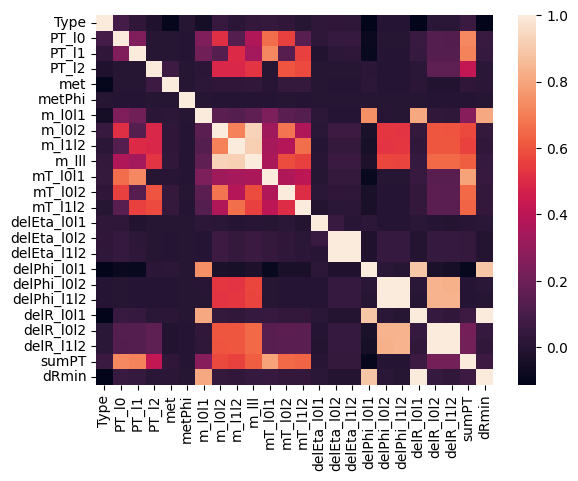

In [75]:
corr_df = df_p.corr()

corr_df.dropna()

sns.heatmap(corr_df,
           xticklabels = corr_df.columns,
           yticklabels=corr_df.columns,
           )
plt.savefig('/localscratch/corro_plot.png')

In [ ]:
featurenames = ['delPhi_l1l2','dRmin']

display_vars = ['delPhi_l1l2', 'dRmin']

#['PT_l0', 'PT_l1', 'PT_l2', 'met','metPhi', \
 #      'm_l0l1','m_l0l2', 'm_l1l2', 'm_lll', \
  #     'mT_l0l1', 'mT_l0l2','mT_l1l2','delPhi_l0l1','delPhi_l0l2',\
   #             'delPhi_l1l2','delR_l0l1','delR_l0l2', 'delR_l1l2','sumPT','dRmin']


sample = df_p

g = sns.pairplot(sample, vars=display_vars, hue='Type')

for feature in featurenames:
    sns.distplot(df_WWW[feature].astype('float64'), kde=False, label='WWW', color='red')
    sns.distplot(df_VH[feature].astype('float64'), kde=False, label='VH', color='cyan')
    sns.distplot(df_bkg[feature].astype('float64'), kde=False, label='bkg', color='blue')

In [40]:
#scale to given luminosity
lumi=400 #inverse fb

n_sig=lumi*xSection_sig*1000
n_bkg=lumi*xSection_bkg*1000

weight_sig=n_sig/N_root_sig
weight_bkg=n_bkg/N_root_bgk

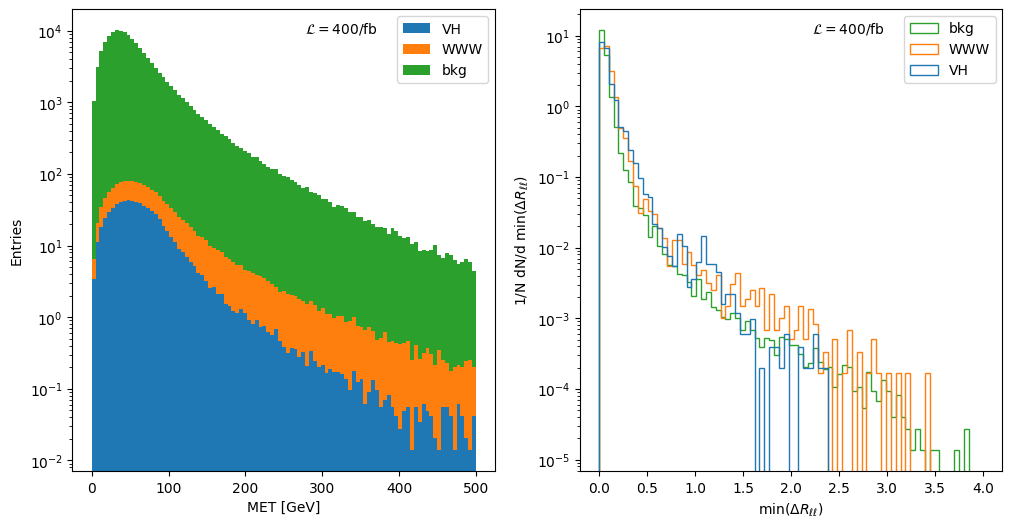

In [41]:
fig,ax=plt.subplots(1,2,figsize=(12,6))
bins=np.linspace(0.,500.,100)
ax[0].hist([df_VH['met'],df_WWW['met'],df_bkg['met']],bins=bins,
        weights=[np.full(df_VH['met'].shape,weight_sig),
                 np.full(df_WWW['met'].shape,weight_sig),
                 np.full(df_bkg['met'].shape,weight_bkg)],
        histtype='bar', stacked=True,label=["VH","WWW","bkg"])
ax[0].set_yscale('log')
ax[0].text(0.55,0.95,"${\\cal L}=%3.0f$/fb"%lumi,transform=ax[0].transAxes)
ax[0].set_xlabel("MET [GeV]")
ax[0].set_ylabel("Entries")
ax[0].legend()

bins=np.linspace(0.,4.,80)
ax[1].hist([df_VH['dRmin'],df_WWW['dRmin'],df_bkg['dRmin']],bins=bins,
        weights=[np.full(df_VH['dRmin'].shape,weight_sig),
                 np.full(df_WWW['dRmin'].shape,weight_sig),
                 np.full(df_bkg['dRmin'].shape,weight_bkg)],
        histtype='step', stacked=False,density=True,label=["VH","WWW","bkg"])
ax[1].set_yscale('log')
ax[1].text(0.55,0.95,"${\\cal L}=%3.0f$/fb"%lumi,transform=ax[1].transAxes)
ax[1].set_xlabel("min($\\Delta R_{\\ell\\ell})$")
ax[1].set_ylabel("1/N dN/d min($\\Delta R_{\\ell\\ell})$")
ax[1].legend()